In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import psi4

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors

In [2]:
import bayes_opt_dis

In [3]:
smiles_df=pd.read_csv("ProcessedData/smiles_chfcl.csv",index_col=0)
display(smiles_df.head())

,SMILES
0,[H]C(F)(F)C([H])([H])C(F)(F)Cl
1,[H]C(F)(Cl)C([H])([H])C(F)(F)F
2,[H]C(Cl)=C=C([H])Cl
3,[H]C([H])(F)C([H])(F)Cl
4,[H]C([H])(Cl)C(F)(F)C(F)(F)Cl


In [4]:
desc_list = Descriptors.descList

desc_values=[]
mol_list=[]
for i,row in smiles_df.iterrows():
    mol=Chem.MolFromSmiles(row["SMILES"])
    mol_list.append(mol)
    desc_value_row=[]
    for desc in desc_list:
        try:
            desc_value_row.append(desc[1](mol))
        except:
            # エラーが発生したものについてはnp.NaNを代入
            desc_value_row.append(np.NaN)
    desc_values.append(desc_value_row)

In [5]:
# 記述子関数の辞書を作る
desc_dict={}
desc_name=[]
for desc in desc_list:
    desc_dict[desc[0]]=desc[1] 
    desc_name.append(desc[0])
    
logp_list=[]
for mol in mol_list:
    logp_list.append(desc_dict["MolLogP"](mol))
logp_df=pd.DataFrame(logp_list,columns=["LogP"])

In [6]:
desc_df=pd.DataFrame(desc_values,columns=desc_name)
# 欠損値を確認
desc_df.isnull().sum().sum()

3

In [7]:
# 欠損値のある列を削除
desc_df=desc_df.dropna(axis=1)
# 欠損値を確認
desc_df.isnull().sum().sum()

0

In [8]:
# 標準偏差が0のものを除去
desc_df2=desc_df.loc[:,desc_df.std()>0]

In [9]:
# 結合
mol_df=pd.DataFrame(mol_list,columns=["mol"])
desc_df3=pd.concat([smiles_df,mol_df,desc_df2],axis=1)
desc_df3.head()
desc_df3.tail()

,SMILES,mol,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,FractionCSP3,HeavyAtomCount,NumHeteroatoms,NumRotatableBonds,MolLogP,MolMR,fr_alkyl_halide,fr_allylic_oxid,fr_halogen,fr_term_acetylene
573,[H]C([H])(F)C([H])([H])C([H])([H])Cl,<rdkit.Chem.rdchem.Mol object at 0x7f6efce35300>,10.909028,-0.288194,10.909028,0.288194,0.458170,96.532,90.484,96.014206,...,1.000000,5,2,2,1.5848,21.312,2,0,2,0
574,[H]C(F)(Cl)C(F)(F)C(F)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7f6efce35620>,11.907407,-4.599537,11.907407,3.243056,0.493847,219.392,218.384,217.907996,...,1.000000,10,7,2,3.2570,31.241,7,0,7,0
575,[H]C(=C(F)F)C([H])([H])Cl,<rdkit.Chem.rdchem.Mol object at 0x7f6efce35530>,10.811806,-1.717593,10.811806,0.108796,0.455403,112.506,109.482,111.989134,...,0.333333,6,3,1,2.0056,21.019,1,1,3,0
576,[H]C(F)(Cl)C(F)(Cl)C(F)(F)Cl,<rdkit.Chem.rdchem.Mol object at 0x7f6efce35a80>,12.096451,-4.518133,12.096451,3.054012,0.493847,219.392,218.384,217.907996,...,1.000000,10,7,2,3.2570,31.241,7,0,7,0
577,[H]C([H])([H])C(F)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7f6efce35c60>,11.218364,-2.055556,11.218364,1.051698,0.425902,116.950,113.926,115.959584,...,1.000000,5,3,0,2.1072,21.219,3,0,3,0


In [10]:
desc_array=desc_df3.iloc[:,2:]

# 標準化
desc_array=desc_array.apply(lambda x: (x-x.mean())/x.std(ddof=1), axis=0)
desc_array.std(axis=0,ddof=1)

MaxEStateIndex       1.0
MinEStateIndex       1.0
MaxAbsEStateIndex    1.0
MinAbsEStateIndex    1.0
qed                  1.0
                    ... 
MolMR                1.0
fr_alkyl_halide      1.0
fr_allylic_oxid      1.0
fr_halogen           1.0
fr_term_acetylene    1.0
Length: 95, dtype: float64

In [11]:
#主成分分析
from sklearn.decomposition import PCA
pca = PCA(n_components= 6)
pca.fit(desc_array)
features = pca.transform(desc_array)
print("PCA後の形:",features.shape)
print('----寄与率----')
print(pca.explained_variance_ratio_)
print('----累計寄与率----')
print(sum(pca.explained_variance_ratio_))

PCA後の形: (578, 6)
----寄与率----
[0.38166336 0.1367142  0.06183531 0.0452691  0.03247552 0.02773757]
----累計寄与率----
0.6856950677550588


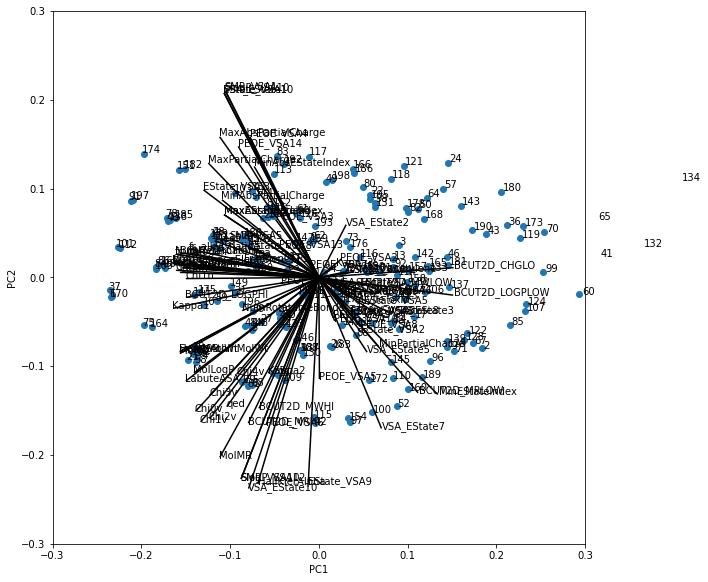

In [12]:
import matplotlib.pyplot as plt

# plot biplot with data
fig=plt.figure(figsize=(10,150))
ax=fig.add_subplot()
for i in range(len(desc_array.columns)):
    pc1_comp=pca.components_[0,i]
    pc2_comp=pca.components_[1,i]
    ax.plot([0,pc1_comp],[0,pc2_comp],color="k")
    ax.text(x=pc1_comp*1.01,y=pc2_comp*1.01,s=desc_array.columns[i])

biplot_scale=0.02
for i in range(200):
    pc1_comp=features[i,0]*biplot_scale
    pc2_comp=features[i,1]*biplot_scale
    ax.scatter(pc1_comp,pc2_comp,color="C0")
    ax.text(x=pc1_comp*1.01,y=pc2_comp*1.01,s=desc_array.index[i])
ax.set_aspect('equal', adjustable='box')
xylim=0.3
ax.set_xlim([-xylim,xylim])
ax.set_ylim([-xylim,xylim])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

plt.tight_layout()

In [13]:
PC_names=["PC{}".format(i+1) for i in range(6)]
ft_value_df=pd.DataFrame(features,columns=PC_names)
ft_df=pd.concat([smiles_df,mol_df,logp_df,ft_value_df],axis=1)
ft_df.head()

,SMILES,mol,LogP,PC1,PC2,PC3,PC4,PC5,PC6
0,[H]C(F)(F)C([H])([H])C(F)(F)Cl,<rdkit.Chem.rdchem.Mol object at 0x7f6f050e8f80>,2.4732,-2.612576,3.464664,1.485989,0.635800,-0.959271,-0.039577
1,[H]C(F)(Cl)C([H])([H])C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x7f6f050ff8f0>,2.4732,-2.773286,3.797525,1.459616,0.370209,-0.931578,-0.059711
2,[H]C(Cl)=C=C([H])Cl,<rdkit.Chem.rdchem.Mol object at 0x7f6f050fff80>,2.0903,9.183354,-3.980349,-4.008467,1.818514,-0.255090,2.296624
3,[H]C([H])(F)C([H])(F)Cl,<rdkit.Chem.rdchem.Mol object at 0x7f6f0510e580>,1.4903,4.486766,1.840215,2.878088,-1.740080,1.326389,-1.712515
4,[H]C([H])(Cl)C(F)(F)C(F)(F)Cl,<rdkit.Chem.rdchem.Mol object at 0x7f6f0510e850>,2.6921,-5.928476,2.381269,0.427639,1.495673,-0.252127,2.434210


# HOMO-LUMO ギャップ計算

In [15]:
# homo lumoギャップ計算
def func(mol_no):
    mol=mol_df.iloc[mol_no,0]
    mol=Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol,AllChem.ETKDGv3())
    xyz_text=Chem.MolToXYZBlock(mol)
    
    xyz_list=xyz_text.splitlines()
    psi4_input="\n".join(xyz_list[2:])

    # 計算手法（汎関数）、基底関数を設定
    level = "b3lyp/6-31G*"

    qua_geo = psi4.geometry(psi4_input)
    
    # quantum calc
    energy, wave_function=psi4.optimize(level,molecule=qua_geo,return_wfn=True)
    
    LUMO_idx=wave_function.nalpha()
    HOMO_idx=LUMO_idx-1

    lumo = swave_function.epsilon_a_subset("AO", "ALL").np[LUMO_idx]
    homo = wave_function.epsilon_a_subset("AO", "ALL").np[HOMO_idx]

    gap=lumo-homo
    
    return gap

In [16]:
bayes_opt_dis=bayes_opt_dis.BayesianOptDiscrete(func,features)
bayes_opt_dis.minimumize_func(niter=1)

Optimizer: Optimization complete!


NameError: name 'swave_function' is not defined